# **A3: Predicting Car Price**
## Dechathon Niamsa-ard st126235
Github Link: https://github.com/dniamsaard4codework/A3-Predicting-Car-Price.git

Link to the website: 


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pickle

# Check MLflow version
print(mlflow.__version__)

/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


2.8.1


## Objective of the assignment
- Convert car price prediction into classification problem using Logistic Regression.
- Implement evaluation metrics (Accuracy, Precision, Recall, F1, Macro, Weighted) from scratch.
- Extend Logistic Regression to include Ridge (L2) regularization.
- Log experiments on the MLflow server.
- Deploy the best model using MLflow Model Registry.
- Set up CI/CD pipeline with GitHub Actions and unit testing.

## Task 1: Classification

In this task, I need to use the preprocessed dataset from A1/A2, and convert `selling_price` into 4 classes (0-3). After that, I need to implement the classification report from scratch, compare with the sklearn's classification report, and answer what support means in the report.

### Load dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/Cars.csv')

# Display the first few rows of the dataframe
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
# Display statistical summary of the dataset
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


### Apply preprocessed from A1/A2 to the dataset

In [5]:
# Perform some data cleaning for better analysis and visualization
# Parse from numeric columns and handle empty strings
df.mileage = pd.to_numeric(df.mileage.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.engine = pd.to_numeric(df.engine.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.max_power = pd.to_numeric(df.max_power.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')

# Rename the columns for better understanding
df = df.rename(columns={'name':'brand'})

# Drop the torque column
df = df.drop(columns=['torque'], errors='ignore')

# Remove all rows with CNG and LPG fuel types
df = df[~df['fuel'].isin(['CNG', 'LPG'])]

# Take the first word of name and remove the rest for brand class
df.brand = df.brand.str.split(' ', expand=True)[0]

# map feature owner to be First owner to 1, ..., Test Drive Car to 5
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
df.owner = df.owner.map(owner_mapping).astype(int)

# Check the dataframe info
df.info()

# Remove the 'Test Drive Car' samples due not to involve in the training
df = df[df['owner'] != 5]

# Create a class that look like the pipeline but using with custom model classes (Same as A2)

# Manual Preprocessor class for data preprocessing
class ManualPreprocessor:
    def __init__(self, num_med_cols, num_mean_cols, cat_cols, drop_first=True):
        self.num_med_cols = list(num_med_cols)
        self.num_mean_cols = list(num_mean_cols)
        self.cat_cols = list(cat_cols)
        self.drop_first = drop_first
        # learned params
        self.medians_ = {}
        self.means_ = {}
        self.num_mean_for_scale_ = {}
        self.num_std_for_scale_ = {}
        self.cat_categories_ = {}
        self.feature_names_ = None
        self.is_fitted_ = False

    # Fit the preprocessor to the data
    def fit(self, X: pd.DataFrame):
        X = X.copy()

        # 1) impute stats
        for c in self.num_med_cols:
            if c in X.columns:
                self.medians_[c] = X[c].median()
        for c in self.num_mean_cols:
            if c in X.columns:
                self.means_[c] = X[c].mean()

        # 2) impute to compute scaler on train
        for c in self.num_med_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.means_[c])

        # 3) scaler stats (column-wise)
        num_all = self.num_med_cols + self.num_mean_cols
        for c in num_all:
            if c in X.columns:
                self.num_mean_for_scale_[c] = X[c].mean()
                self.num_std_for_scale_[c] = X[c].std(ddof=0)
                # Ensure std is not zero
                if self.num_std_for_scale_[c] == 0:
                    self.num_std_for_scale_[c] = 1.0

        # 4) categorical categories (store train cats; unknowns will be ignored)
        for c in self.cat_cols:
            if c in X.columns:
                cats = pd.Index(pd.Series(X[c], dtype="object").dropna().unique())
                # Use a deterministic order:
                self.cat_categories_[c] = pd.Index(sorted(cats.astype(str)))

        # 5) build feature names (without bias)
        self._build_feature_names()
        self.is_fitted_ = True
        return self

    # Helper method to build feature names
    def _build_feature_names(self):
        """Helper method to build feature names"""
        num_names = self.num_med_cols + self.num_mean_cols
        cat_names = []
        for c in self.cat_cols:
            if c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # drop_first=True -> drop the first category
                cats_keep = cats[1:] if self.drop_first and len(cats) > 0 else cats
                cat_names += [f"{c}={val}" for val in cats_keep] 
        self.feature_names_ = np.array(num_names + cat_names, dtype=object)

    # Transform the data using the fitted preprocessor
    def transform(self, X: pd.DataFrame) -> np.ndarray:
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before transform")
        
        X = X.copy()

        # 1) impute using train stats
        for c in self.num_med_cols:
            if c in X.columns and c in self.medians_:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns and c in self.means_:
                X[c] = X[c].fillna(self.means_[c])

        # 2) scale numeric
        num_all = self.num_med_cols + self.num_mean_cols
        X_num = []
        for c in num_all:
            if c in X.columns and c in self.num_mean_for_scale_:
                mu = self.num_mean_for_scale_[c]
                sd = self.num_std_for_scale_[c]
                X_num.append(((X[c].astype(float) - mu) / sd).to_numpy())
        X_num = np.column_stack(X_num) if X_num else np.empty((len(X), 0))

        # 3) one-hot categorical using TRAIN categories
        X_cat_parts = []
        for c in self.cat_cols:
            if c in X.columns and c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # force to training categories (unknown -> NaN -> all zeros after dummies)
                col = pd.Categorical(X[c].astype("object"), categories=cats)
                dummies = pd.get_dummies(col, prefix=c, prefix_sep='=', dummy_na=False) # get dummies
                # drop first category to avoid collinearity
                if self.drop_first and dummies.shape[1] > 0:
                    dummies = dummies.iloc[:, 1:]  # drop first category
                X_cat_parts.append(dummies.to_numpy(dtype=float))
        X_cat = np.column_stack(X_cat_parts) if X_cat_parts else np.empty((len(X), 0))

        # 4) concat numeric + categorical
        X_all = np.column_stack([X_num, X_cat]) if X_num.size > 0 or X_cat.size > 0 else np.empty((len(X), 0))

        # 5) add bias as first column
        bias = np.ones((X_all.shape[0], 1), dtype=float)
        X_with_bias = np.hstack([bias, X_all])
        return X_with_bias

    # Fit and transform the data
    def fit_transform(self, X: pd.DataFrame) -> np.ndarray:
        return self.fit(X).transform(X)

    # Get feature names after fitting
    def get_feature_names(self, include_bias=False):
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before getting feature names")
        if include_bias:
            return np.array(["bias"] + list(self.feature_names_), dtype=object)  # Include bias term
        return self.feature_names_.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   int64  
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  seats          7819 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 815.9+ KB


In [6]:
# Check the range of the selling_price column
print(f"Range of selling_price: {df['selling_price'].min()} to {df['selling_price'].max()}")
# Check the quartiles of the selling_price column
print(df['selling_price'].quantile([0.25, 0.5, 0.75]))

Range of selling_price: 29999 to 10000000
0.25    260000.0
0.50    450000.0
0.75    680000.0
Name: selling_price, dtype: float64


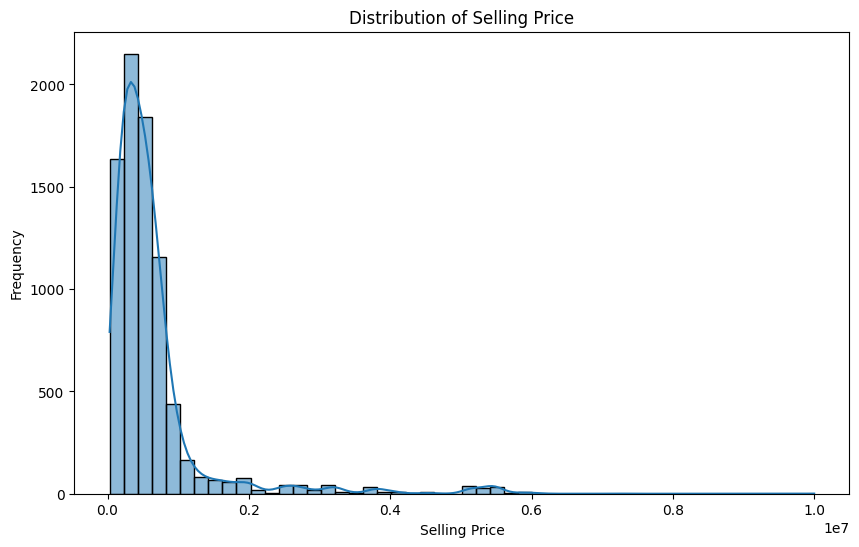

In [7]:
# Display the distribution of the selling_price column
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

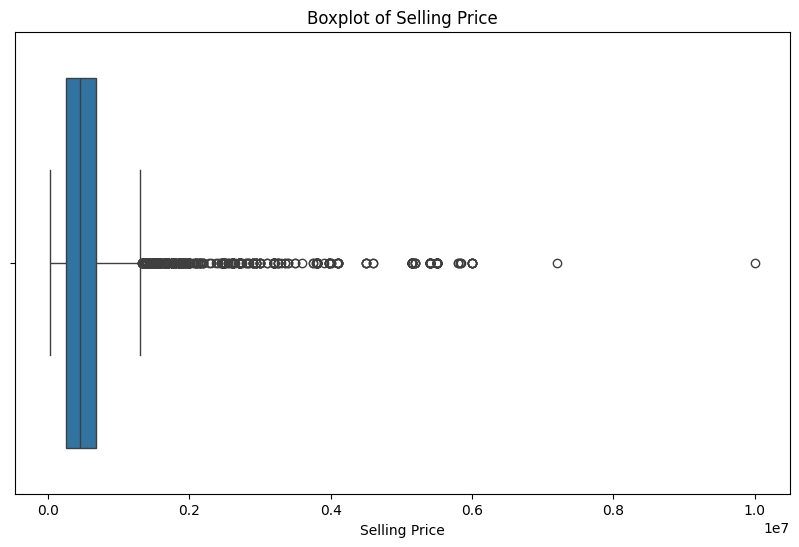

In [8]:
# Show boxplot to identify outliers in selling_price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['selling_price'])
plt.title('Boxplot of Selling Price')
plt.xlabel('Selling Price')
plt.show()

In [9]:
# Convert 'selling_price' to 'price_class' categorical variable with quartiles
# bins = [0, 200000, 500000, 1000000, df['selling_price'].max()]
# labels = [0,1,2,3]
# df['price_class'] = pd.cut(df['selling_price'], bins=bins, labels=labels, include_lowest=True)

# Separate with pd.cut with quantiles
quantiles = df['selling_price'].quantile([0,0.25,0.5,0.75,1]).values
df['price_class'] = pd.cut(
    df['selling_price'],
    bins=quantiles,
    labels=[0,1,2,3],
    include_lowest=True
)
df.price_class.value_counts().sort_index() # check the distribution of price_class

price_class
0    2050
1    2044
2    1943
3    1991
Name: count, dtype: int64

In [10]:
# Display the first few rows of the dataframe
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,price_class
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,1
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,1
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,0


In [11]:
# Convert 'price_class' to categorical type
df['price_class'] = df['price_class'].astype('category')
# Show the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   brand          8028 non-null   object  
 1   year           8028 non-null   int64   
 2   selling_price  8028 non-null   int64   
 3   km_driven      8028 non-null   int64   
 4   fuel           8028 non-null   object  
 5   seller_type    8028 non-null   object  
 6   transmission   8028 non-null   object  
 7   owner          8028 non-null   int64   
 8   mileage        7814 non-null   float64 
 9   engine         7814 non-null   float64 
 10  max_power      7820 non-null   float64 
 11  seats          7814 non-null   float64 
 12  price_class    8028 non-null   category
dtypes: category(1), float64(4), int64(4), object(4)
memory usage: 823.4+ KB


In [12]:
# Select relevant features for the model
features = ['year', 'km_driven', 'fuel', 'transmission', 'owner',
            'engine', 'max_power', 'brand', 'mileage']
target = 'price_class'
print(features)

['year', 'km_driven', 'fuel', 'transmission', 'owner', 'engine', 'max_power', 'brand', 'mileage']


In [13]:
from sklearn.model_selection import train_test_split

# Split training set and testing set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
# Create feature sets for numerical and categorical features
features_num = [ft for ft in features if train_set[ft].dtype in [np.float64, np.int64]]
features_cat = [ft for ft in features if train_set[ft].dtype == 'object']

print("Numerical features:", features_num)
print("Categorical features:", features_cat)

Numerical features: ['year', 'km_driven', 'owner', 'engine', 'max_power', 'mileage']
Categorical features: ['fuel', 'transmission', 'brand']


In [15]:
# Split the data into features and target label
X_train = train_set[features].copy()
X_test = test_set[features].copy()
y_train = train_set[target].copy()
y_test = test_set[target].copy()

In [16]:
# Check the shapes of the datasets
print("The shape of training data is:", X_train.shape) # check the shape of training data
print("The shape of test data is:", X_test.shape) # check the shape of test data
print("The shape of training label is:", y_train.shape) # check the shape of training label
print("The shape of test label is:", y_test.shape) # check the shape of test label

The shape of training data is: (6422, 9)
The shape of test data is: (1606, 9)
The shape of training label is: (6422,)
The shape of test label is: (1606,)


In [17]:
# Define numerical columns for median and mean imputation
num_med_cols = [c for c in features_num if c != 'mileage']
num_mean_cols = ['mileage']

# Define categorical columns
cat_cols = features_cat

prep = ManualPreprocessor(num_med_cols, num_mean_cols, cat_cols, drop_first=True) # Apply to the code for ManualPreprocessor
X_train_transformed = prep.fit_transform(X_train) # Fit and transform the training data
X_test_transformed = prep.transform(X_test) # Transform the test data

# Display the shape of transformed data
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

# Display the type of transformed data
print("Type of X_train_transformed:", type(X_train_transformed))
print("Type of X_test_transformed:", type(X_test_transformed))
print("Type of y_train:", type(y_train))
print("Type of y_test:", type(y_test))

X_train_transformed shape: (6422, 38)
X_test_transformed shape: (1606, 38)
y train shape: (6422,)
y test shape: (1606,)
Type of X_train_transformed: <class 'numpy.ndarray'>
Type of X_test_transformed: <class 'numpy.ndarray'>
Type of y_train: <class 'pandas.core.series.Series'>
Type of y_test: <class 'pandas.core.series.Series'>


In [18]:
# Create one-hot encoded arrays for training
def to_one_hot(y, num_classes):
    """Convert numeric labels to one-hot encoding"""
    y = y.cat.codes  # Convert categorical to numeric codes
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

# Convert to one-hot for the model for 4 classes
y_train_one_hot = to_one_hot(y_train, 4)

# Display the shape of one-hot encoded labels
print("Original y_train shape:", y_train.shape)
print("One-hot y_train shape:", y_train_one_hot.shape)

# Verify the conversion
print("\nFirst few y_train values:", y_train.head().values)
print("First few y_train:", y_train[:5])
print("First few y_train_one_hot:")
print(y_train_one_hot[:5])

Original y_train shape: (6422,)
One-hot y_train shape: (6422, 4)

First few y_train values: [0, 0, 0, 3, 0]
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train: 2982    0
2430    0
6294    0
6255    3
4253    0
Name: price_class, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train_one_hot:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### Modify LogisticRegression() class from `02 - Multinomial Logistic Regression.ipynb` 


In [19]:
class LogisticRegression(object):
    
    # Initialize the model with hyperparameters
    def __init__(self, regularization, k, n, method, alpha = 0.001, max_iter=5000):
        self.k = k # number of classes
        self.n = n # number of features
        self.alpha = alpha # learning rate
        self.max_iter = max_iter # maximum number of iterations
        self.method = method # optimization method
        self.regularization = regularization # regularization method
    
    # Fit the model to the training data
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k)
        self.losses = []
        
        # Choose optimization method
        if self.method == "batch": # batch gradient descent
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch": # mini-batch gradient descent
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement sampling
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")

        elif self.method == "sto": # stochastic gradient descent
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
    # Compute the gradient and loss    
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        loss = - np.sum(Y*np.log(h)) / m  
        loss += self.regularization(self.W, m) # add regularization term to the loss
        error = h - Y
        grad = self.softmax_grad(X, error) 
        grad += self.regularization.derivative(self.W, m) # add regularization term to the gradient
        return loss, grad

    # Softmax function
    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    # Gradient of the softmax function
    def softmax_grad(self, X, error):
        return  X.T @ error

    # Hypothesis function
    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    # Predict the class labels for the test data
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    # Plot the training losses over iterations
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

    # Evaluation metrics
    # Compute accuracy
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    # Compute precision for a specific class
    def precision(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        return TP / (TP + FP) if (TP + FP) > 0 else 0.0

    # Compute recall for a specific class
    def recall(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        return TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # Compute F1-score for a specific class
    def f1_score(self, y_true, y_pred, cls):
        prec = self.precision(y_true, y_pred, cls)
        rec = self.recall(y_true, y_pred, cls)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

    # Macro and weighted averages
    # Compute macro precision
    def macro_precision(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.precision(y_true, y_pred, cls) for cls in classes])

    # Compute macro recall
    def macro_recall(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.recall(y_true, y_pred, cls) for cls in classes])

    # Compute macro F1-score
    def macro_f1_score(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.f1_score(y_true, y_pred, cls) for cls in classes])

    # Compute weighted precision, recall, and F1-score
    def weighted_precision(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.precision(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Compute weighted recall
    def weighted_recall(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.recall(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Compute weighted F1-score
    def weighted_f1_score(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.f1_score(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Generate a classification report similar to sklearn's classification_report
    def classification_report(self, y_true, y_pred, digits=2):
        classes, counts = np.unique(y_true, return_counts=True)
        total_support = np.sum(counts)

        report = {}

        # Per-class metrics
        for cls, count in zip(classes, counts):
            cls_str = str(cls)
            p = self.precision(y_true, y_pred, cls)
            r = self.recall(y_true, y_pred, cls)
            f = self.f1_score(y_true, y_pred, cls)
            report[cls_str] = {
                "precision": round(p, digits),
                "recall": round(r, digits),
                "f1-score": round(f, digits),
                "support": int(count)
            }

        # Accuracy
        acc = self.accuracy(y_true, y_pred)
        report["accuracy"] = {
            "precision": "",
            "recall": "",
            "f1-score": round(acc, digits),
            "support": int(total_support)
        }

        # Macro avg
        macro_p = self.macro_precision(y_true, y_pred)
        macro_r = self.macro_recall(y_true, y_pred)
        macro_f = self.macro_f1_score(y_true, y_pred)
        report["macro avg"] = {
            "precision": round(macro_p, digits),
            "recall": round(macro_r, digits),
            "f1-score": round(macro_f, digits),
            "support": int(total_support)
        }

        # Weighted avg
        weighted_p = self.weighted_precision(y_true, y_pred)
        weighted_r = self.weighted_recall(y_true, y_pred)
        weighted_f = self.weighted_f1_score(y_true, y_pred)
        report["weighted avg"] = {
            "precision": round(weighted_p, digits),
            "recall": round(weighted_r, digits),
            "f1-score": round(weighted_f, digits),
            "support": int(total_support)
        }

        return pd.DataFrame(report).T

    

## Task 2: Ridge Logistic Regression

- Add Ridge Logistic Regression
    $$J(\theta) = -\sum_{i=1}^m y^{(i)}\log(h^{(i)}) + \lambda\sum_{j=1}^n \theta_j^{2}$$

In [20]:
# Define Ridge regularization and No regularization classes
class RidgePenalty:
    def __init__(self, l2):
        self.l2 = l2 # regularization strength

    def __call__(self, theta, m):
        return (self.l2 / (2 * m)) * np.sum(np.square(theta)) # L2 regularization term for loss

    def derivative(self, theta, m):
        return (2 * self.l2 / m) * theta # Derivative of L2 regularization term for gradient

# Define No regularization class
class NoPenalty:
    def __call__(self, theta, m=None):
        return 0.0

    def derivative(self, theta, m=None):
        return np.zeros_like(theta)

# Define Ridge and Simple Logistic Regression classes from LogisticRegression
# Ridge regression with L2 regularization
class Ridge(LogisticRegression):
    def __init__(self, k, n, method, alpha, l2):
        self.regularization = RidgePenalty(l2)
        super().__init__(self.regularization, k, n, method, alpha)

# Simple logistic regression without regularization
class SimpleLogistic(LogisticRegression):
    def __init__(self, k, n, method, alpha):
        self.regularization = NoPenalty()
        super().__init__(self.regularization, k, n, method, alpha)

Loss at iteration 0 1.3374955167154108
Loss at iteration 500 1.1175181543254677
Loss at iteration 1000 1.0948142590153858
Loss at iteration 1500 1.0894864904837984
Loss at iteration 2000 1.087239325621917
Loss at iteration 2500 1.0858722075719098
Loss at iteration 3000 1.0849073591754588
Loss at iteration 3500 1.0841948006394673
Loss at iteration 4000 1.0836637694738642
Loss at iteration 4500 1.0832680826819698
time taken: 4.259803295135498
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.93      0.62      0.74       411
           1       0.54      0.87      0.66       456
           2       0.53      0.11      0.19       352
           3       0.69      0.93      0.79       387

    accuracy                           0.65      1606
   macro avg       0.67      0.63      0.60      1606
weighted avg       0.67      0.65      0.61      1606

Report from custom model: 
              precision recall f1-score suppor

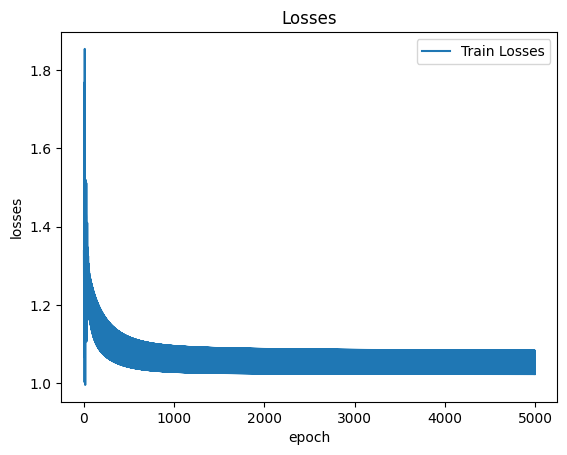

In [21]:
# Test the model and classification report with the car dataset for Ridge regression
# Train the model with properly formatted data
model = Ridge(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001, l2=0.1)
model.fit(X_train_transformed, y_train_one_hot)
yhat = model.predict(X_test_transformed)
model.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("Report from custom model: \n", model.classification_report(y_test, yhat))

Loss at iteration 0 1.706049313138387
Loss at iteration 500 1.0375715834138872
Loss at iteration 1000 1.024360513763744
Loss at iteration 1500 1.0213688296902863
Loss at iteration 2000 1.0201791239496185
Loss at iteration 2500 1.0194512761329566
Loss at iteration 3000 1.018902606317725
Loss at iteration 3500 1.0184535401520967
Loss at iteration 4000 1.018074289652207
Loss at iteration 4500 1.0177499688020732
time taken: 4.210788011550903
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.71      0.95      0.81       411
           1       0.70      0.16      0.26       456
           2       0.46      0.89      0.61       352
           3       0.94      0.64      0.76       387

    accuracy                           0.64      1606
   macro avg       0.70      0.66      0.61      1606
weighted avg       0.71      0.64      0.60      1606

Report from custom model: 
              precision recall f1-score support
0

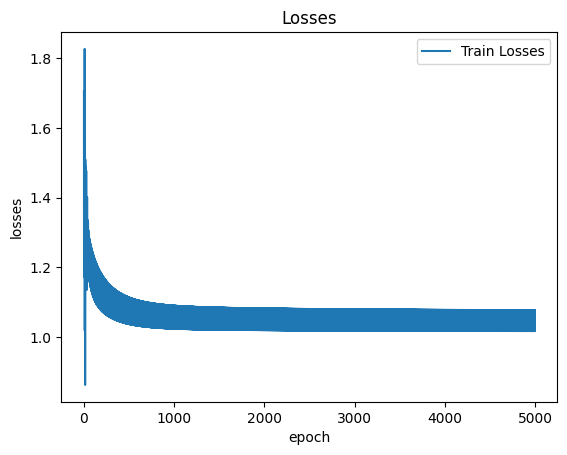

In [22]:
# Test the model and classification report with the car dataset for simple logistic regression
# Train the model with properly formatted data
model2 = SimpleLogistic(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001)
model2.fit(X_train_transformed, y_train_one_hot)
yhat2 = model2.predict(X_test_transformed)
model2.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat2))
print("Report from custom model: \n", model2.classification_report(y_test, yhat2))

## Task 3: Deployment

### Set up MLFlow

In [23]:
# Set up MLflow tracking
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
os.environ["LOGNAME"] = "st126235"
mlflow.set_experiment("st126235-a3")

<Experiment: artifact_location='mlflow-artifacts:/607305997044080535', creation_time=1759391076743, experiment_id='607305997044080535', last_update_time=1759391076743, lifecycle_stage='active', name='st126235-a3', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [24]:
# Helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

===== Training SimpleLogistic with batch and learning rate 0.01 =====
Loss at iteration 0 1.4944932945792282


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_76678/760719979.py:69: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_76678/760719979.py:69: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
time taken: 4.461516857147217


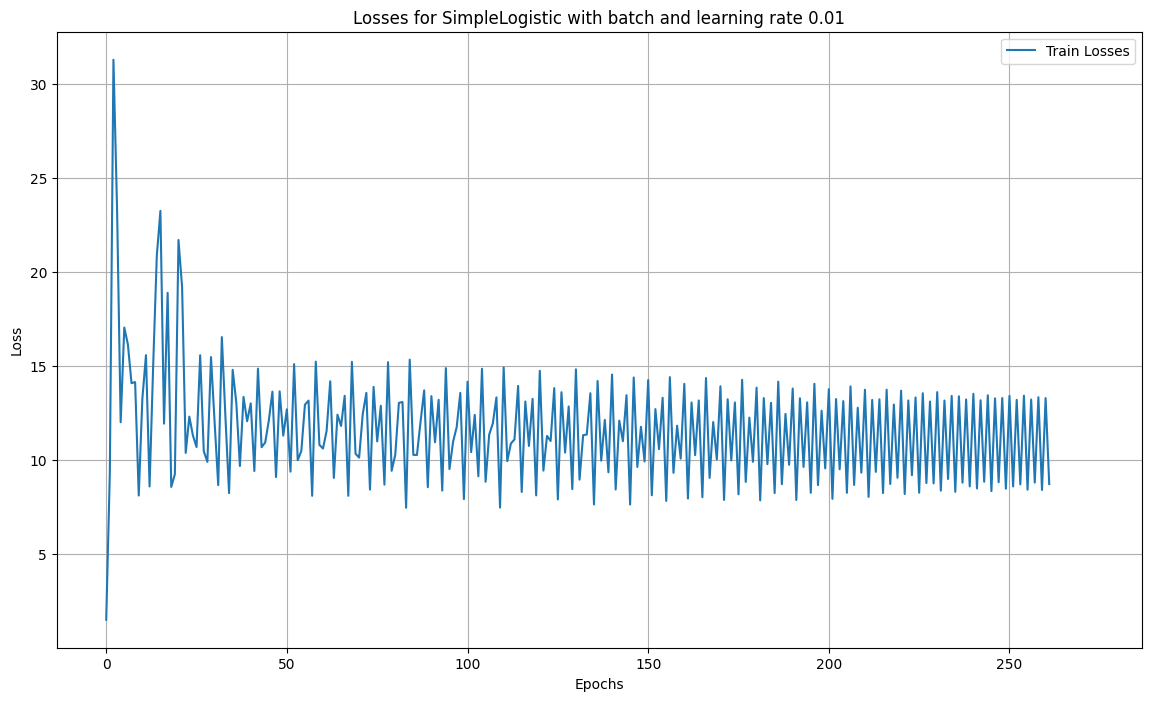

=========Classification report=======
             precision recall f1-score support
0                 0.94   0.56      0.7   411.0
1                 0.52   0.88     0.65   456.0
2                  0.5   0.08     0.14   352.0
3                 0.68   0.93     0.79   387.0
accuracy                          0.64    1606
macro avg         0.66   0.61     0.57  1606.0
weighted avg      0.66   0.64     0.59  1606.0
===== Training SimpleLogistic with batch and learning rate 0.001 =====
Loss at iteration 0 1.6336658724694693
Loss at iteration 500 1.113995483442841
Loss at iteration 1000 1.090463350159074
Loss at iteration 1500 1.0847866749886401
Loss at iteration 2000 1.0823061056876446
Loss at iteration 2500 1.0807495713630777
Loss at iteration 3000 1.079626402102749
Loss at iteration 3500 1.0787782041000236
Loss at iteration 4000 1.078125773268026
Loss at iteration 4500 1.077616792968703
time taken: 3.958692789077759


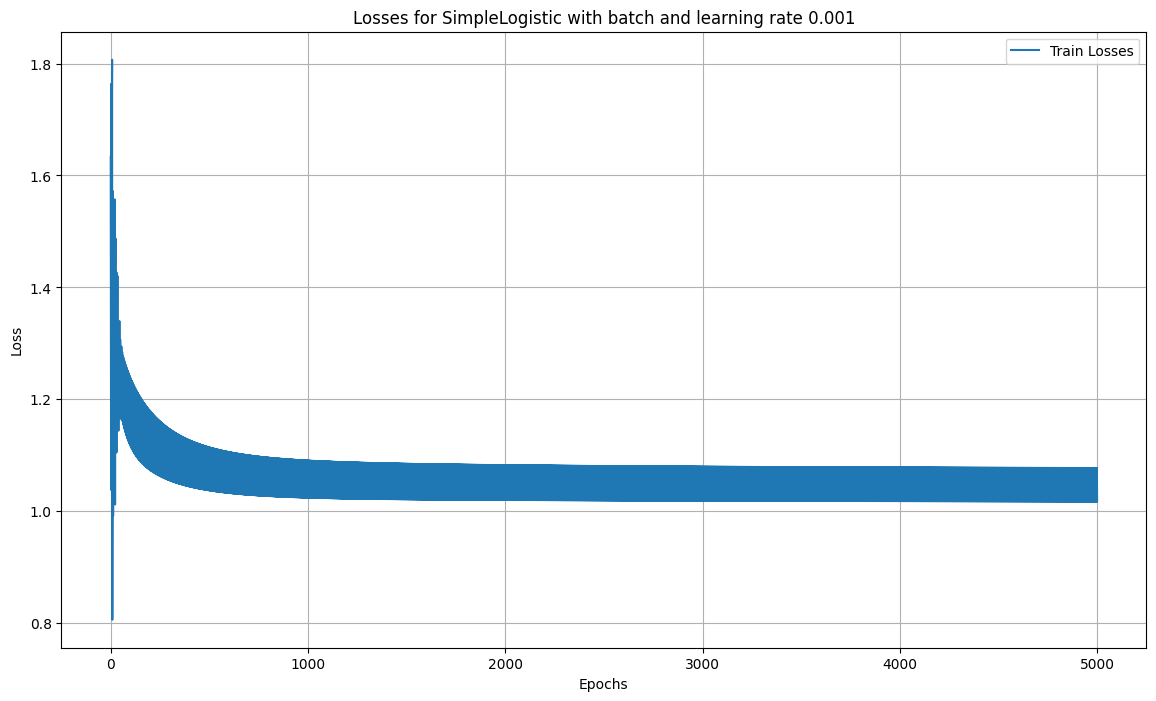

=========Classification report=======
             precision recall f1-score support
0                 0.93   0.62     0.74   411.0
1                 0.54   0.87     0.66   456.0
2                 0.53   0.11     0.19   352.0
3                 0.69   0.93     0.79   387.0
accuracy                          0.65    1606
macro avg         0.67   0.63      0.6  1606.0
weighted avg      0.67   0.65     0.61  1606.0
===== Training SimpleLogistic with batch and learning rate 0.0001 =====
Loss at iteration 0 1.416787250959073
Loss at iteration 500 0.6099933171006738
Loss at iteration 1000 0.5921303125829075
Loss at iteration 1500 0.5859727348054575
Loss at iteration 2000 0.5831658927539618
Loss at iteration 2500 0.5816698532624955
Loss at iteration 3000 0.5807746200602961
Loss at iteration 3500 0.5801862891778966
Loss at iteration 4000 0.5797687320412449
Loss at iteration 4500 0.5794534034071429
time taken: 4.098955154418945


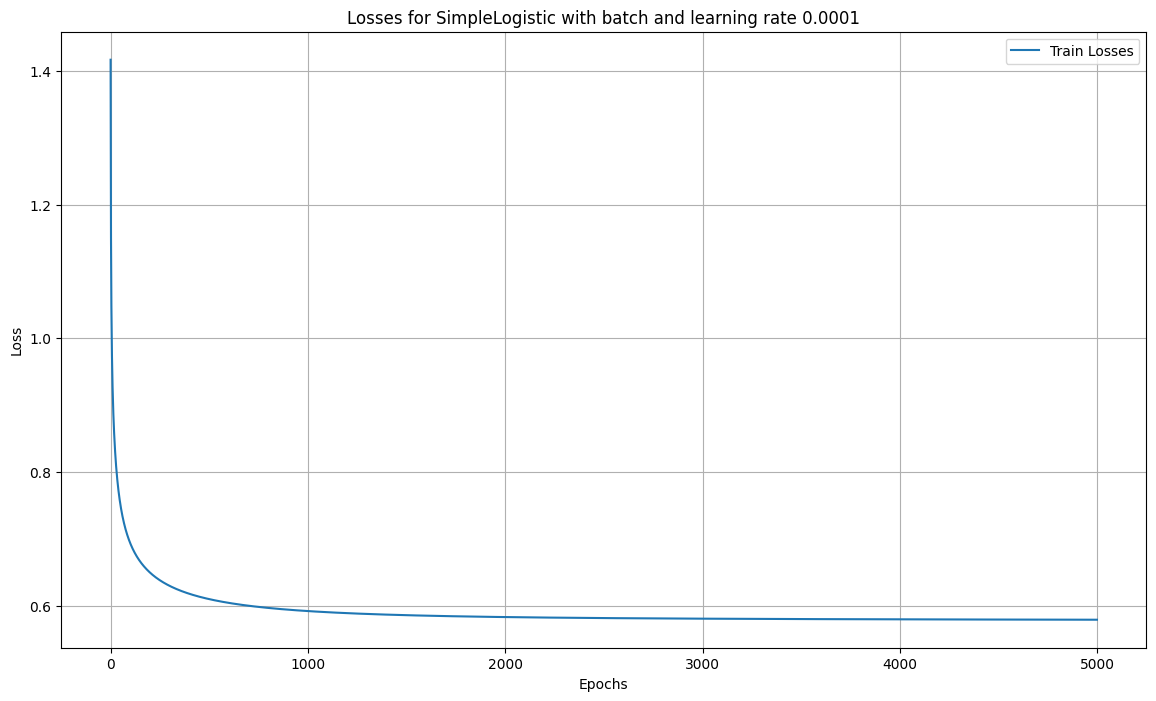

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.84     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.8479587885580475
Loss at iteration 500 2.826673135674921
Loss at iteration 1000 3.1365774009862863
Loss at iteration 1500 1.910177579638989
Loss at iteration 2000 1.2115397328366837
Loss at iteration 2500 1.9579004312193808
Loss at iteration 3000 2.754921180515905
Loss at iteration 3500 1.9795952775470653
Loss at iteration 4000 3.058646003716884
Loss at iteration 4500 1.3679778413623014
time taken: 1.2794160842895508


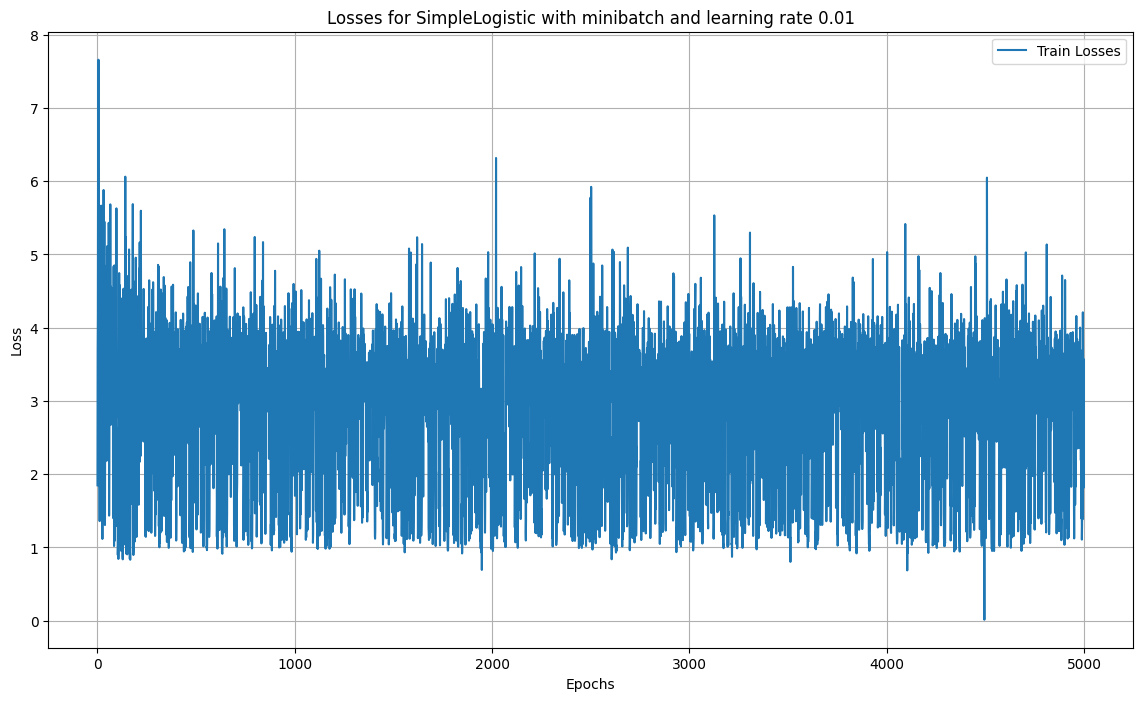

=========Classification report=======
             precision recall f1-score support
0                 0.63   0.98     0.76   411.0
1                 0.82   0.02     0.04   456.0
2                 0.46   0.93     0.61   352.0
3                 0.95   0.59     0.73   387.0
accuracy                           0.6    1606
macro avg         0.71   0.63     0.54  1606.0
weighted avg      0.72    0.6     0.52  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.662440781707677
Loss at iteration 500 0.5907572746603733
Loss at iteration 1000 0.5738543355315988
Loss at iteration 1500 0.6698404046249233
Loss at iteration 2000 0.6128542516060005
Loss at iteration 2500 0.555823176213283
Loss at iteration 3000 0.5783949047074364
Loss at iteration 3500 0.5837664033071771
Loss at iteration 4000 0.5472917150500278
Loss at iteration 4500 0.578033638204367
time taken: 1.2529101371765137


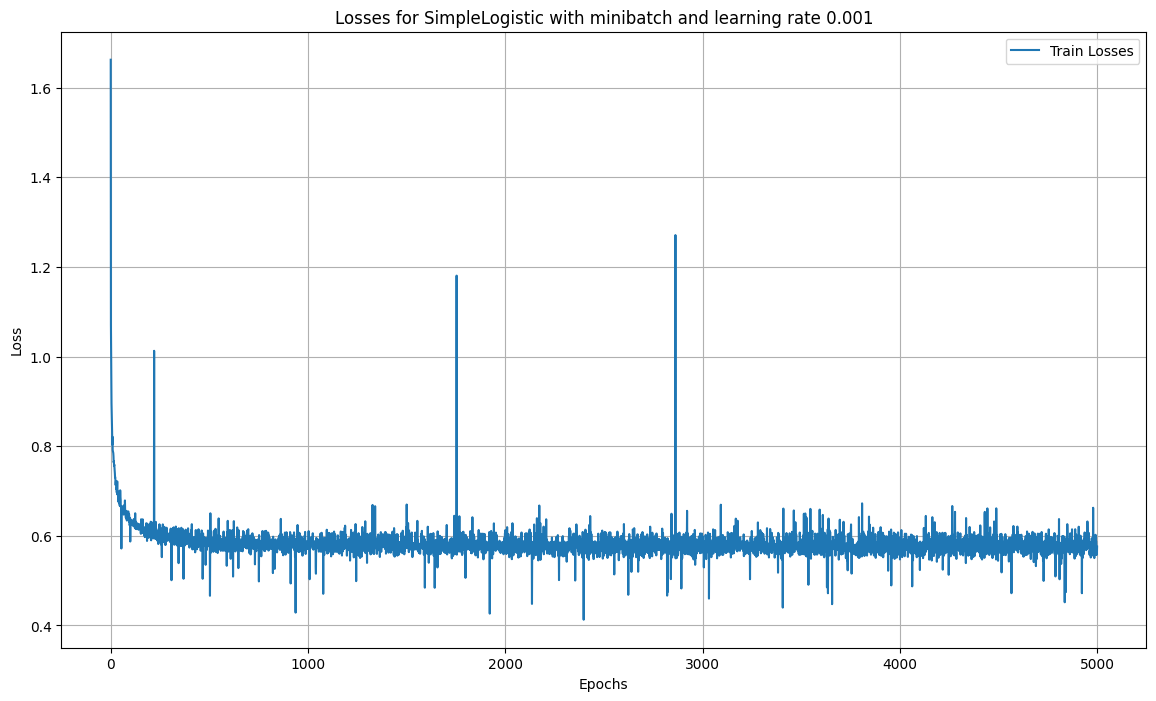

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.84     0.85   411.0
1                 0.71   0.69      0.7   456.0
2                 0.63   0.69     0.66   352.0
3                 0.88   0.84     0.86   387.0
accuracy                          0.77    1606
macro avg         0.77   0.77     0.77  1606.0
weighted avg      0.77   0.77     0.77  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.0001 =====
Loss at iteration 0 2.002867946530653
Loss at iteration 500 0.6739310445763481
Loss at iteration 1000 0.6291949725741062
Loss at iteration 1500 0.6130476062094005
Loss at iteration 2000 0.5998148826023159
Loss at iteration 2500 0.5868092469346461
Loss at iteration 3000 0.6150365797512549
Loss at iteration 3500 0.5898241587571948
Loss at iteration 4000 0.5976684583394919
Loss at iteration 4500 0.6075781950906445
time taken: 1.1559491157531738


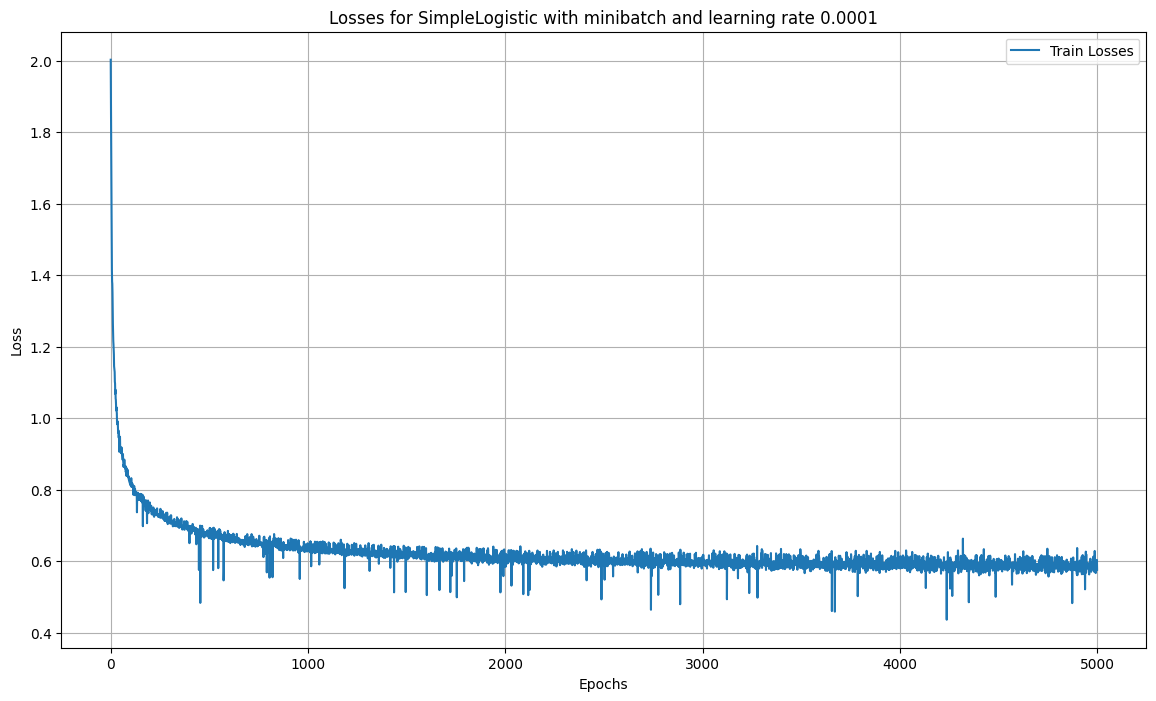

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.82     0.83   411.0
1                 0.69   0.68     0.69   456.0
2                 0.61   0.67     0.64   352.0
3                 0.86   0.83     0.85   387.0
accuracy                          0.75    1606
macro avg         0.75   0.75     0.75  1606.0
weighted avg      0.76   0.75     0.75  1606.0
===== Training SimpleLogistic with sto and learning rate 0.01 =====
Loss at iteration 0 0.5591659042689352
Loss at iteration 500 1.1918980073945762
Loss at iteration 1000 1.171602500278247
Loss at iteration 1500 1.0026881428812404
Loss at iteration 2000 0.5335041484914996
Loss at iteration 2500 0.5053288019266489
Loss at iteration 3000 1.158217687078842
Loss at iteration 3500 0.9636646663953993
Loss at iteration 4000 0.7921510786981599
Loss at iteration 4500 0.04590863930136561
time taken: 0.1526951789855957


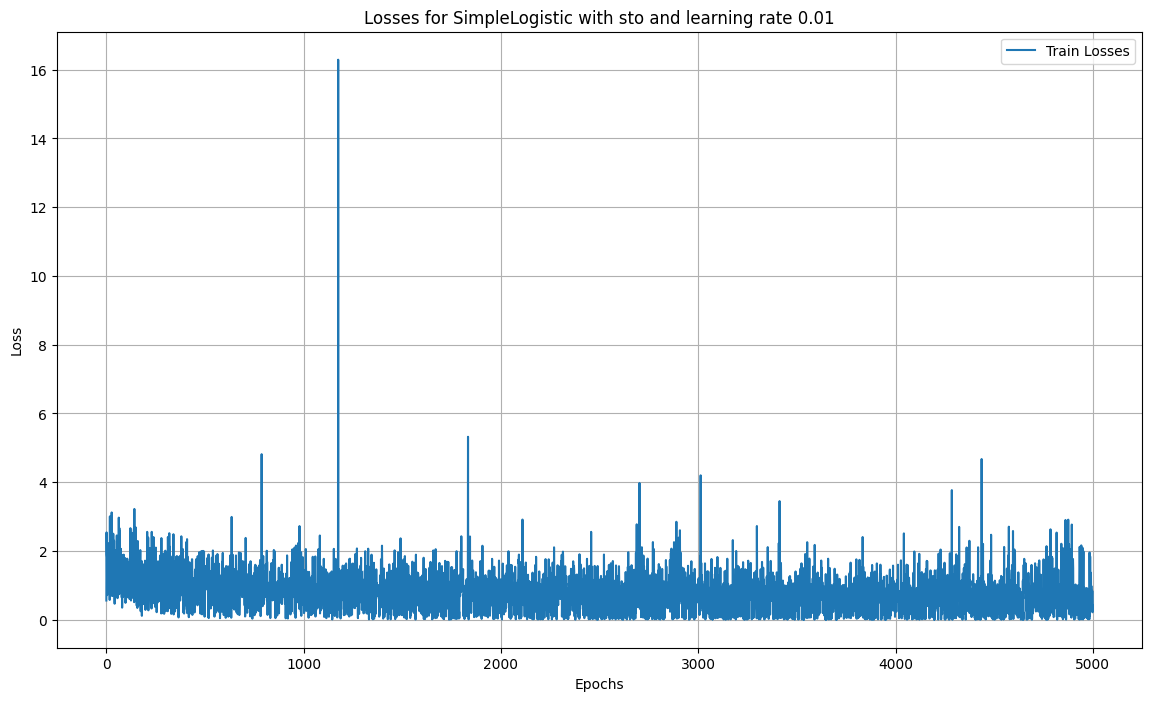

=========Classification report=======
             precision recall f1-score support
0                  0.8   0.88     0.84   411.0
1                 0.66    0.5     0.57   456.0
2                  0.5   0.68     0.58   352.0
3                 0.82    0.7     0.76   387.0
accuracy                          0.69    1606
macro avg          0.7   0.69     0.69  1606.0
weighted avg       0.7   0.69     0.69  1606.0
===== Training SimpleLogistic with sto and learning rate 0.001 =====
Loss at iteration 0 1.8515998509132252
Loss at iteration 500 2.043329049038158
Loss at iteration 1000 2.438354881493106
Loss at iteration 1500 1.4226475359853081
Loss at iteration 2000 0.8472446182381658
Loss at iteration 2500 0.9419824783118282
Loss at iteration 3000 1.4973130848389389
Loss at iteration 3500 0.48018955791496903
Loss at iteration 4000 0.22605201769308053
Loss at iteration 4500 1.1369309624417996
time taken: 0.15489792823791504


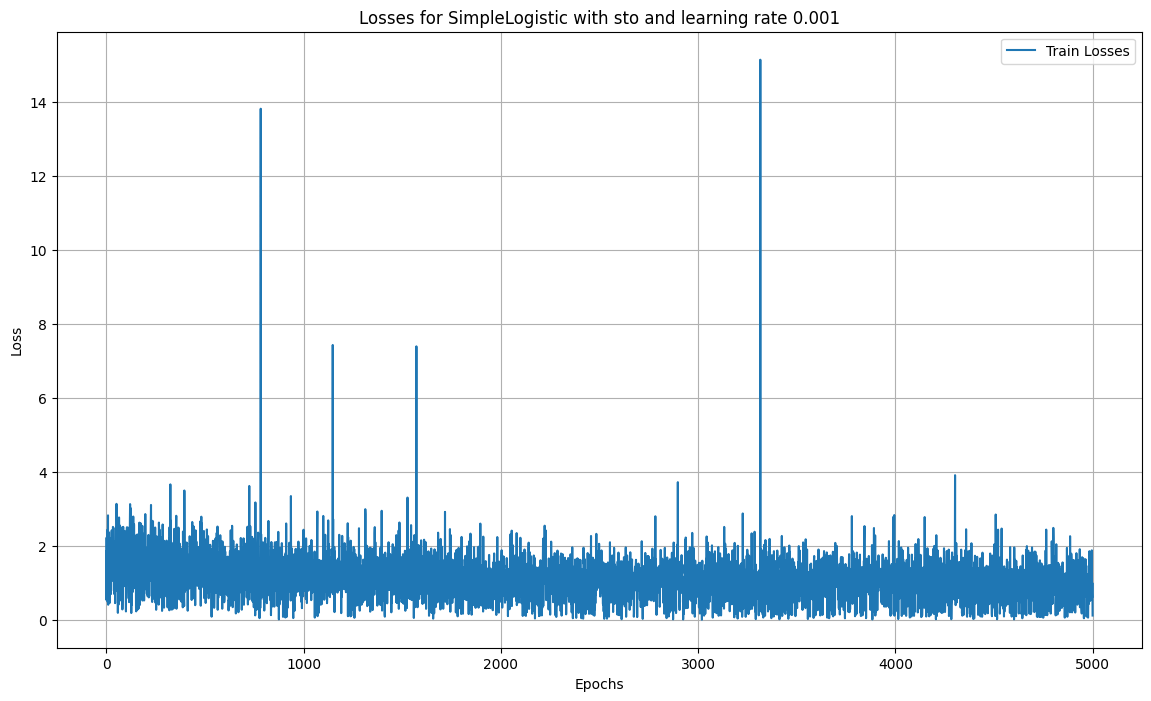

=========Classification report=======
             precision recall f1-score support
0                 0.67   0.75     0.71   411.0
1                  0.5   0.38     0.43   456.0
2                 0.37   0.44      0.4   352.0
3                 0.68   0.65     0.66   387.0
accuracy                          0.55    1606
macro avg         0.55   0.56     0.55  1606.0
weighted avg      0.56   0.55     0.55  1606.0
===== Training SimpleLogistic with sto and learning rate 0.0001 =====
Loss at iteration 0 1.9544455155771714
Loss at iteration 500 1.5345814998272973
Loss at iteration 1000 2.6292247956113886
Loss at iteration 1500 1.644092881070305
Loss at iteration 2000 2.4469580129851196
Loss at iteration 2500 1.71240448735897
Loss at iteration 3000 1.3388707229788936
Loss at iteration 3500 1.1650502982990847
Loss at iteration 4000 1.6333309984005193
Loss at iteration 4500 2.2812327970539235
time taken: 0.11963295936584473


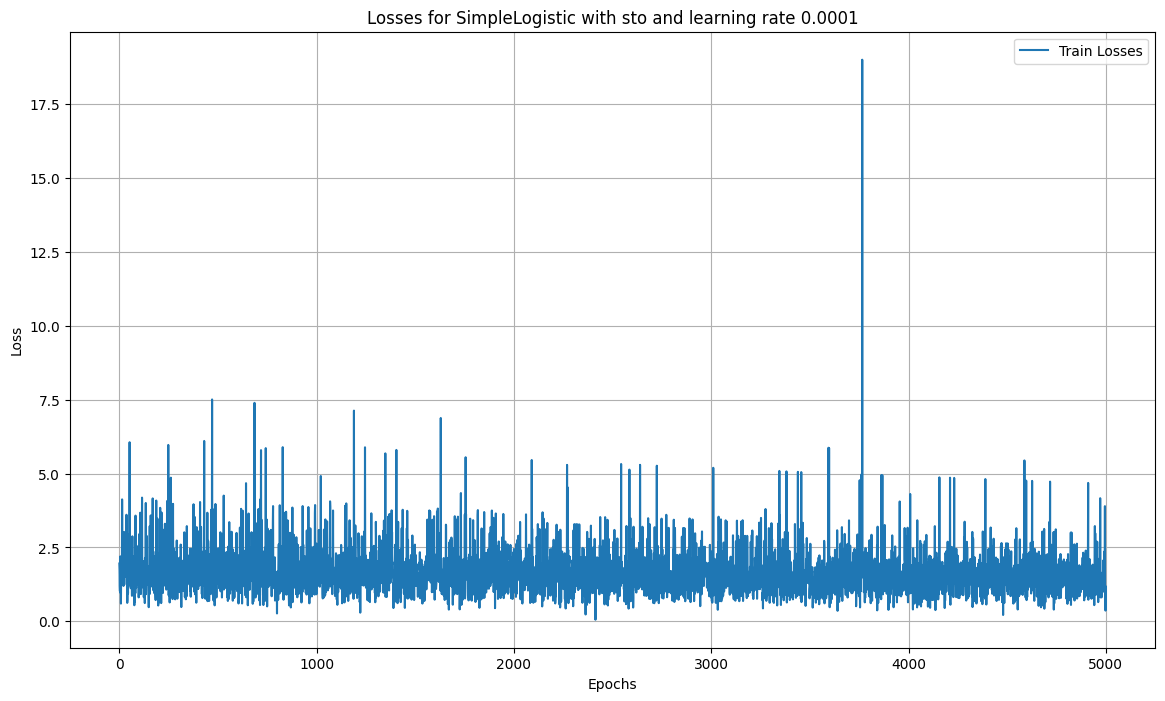

=========Classification report=======
             precision recall f1-score support
0                 0.42   0.38      0.4   411.0
1                 0.22   0.12     0.16   456.0
2                 0.29   0.42     0.34   352.0
3                 0.01   0.01     0.01   387.0
accuracy                          0.23    1606
macro avg         0.23   0.23     0.23  1606.0
weighted avg      0.23   0.23     0.22  1606.0
===== Training Ridge with batch and learning rate 0.01 =====
Loss at iteration 0 1.5446366873143038


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_76678/760719979.py:69: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_76678/760719979.py:69: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
time taken: 3.6386849880218506


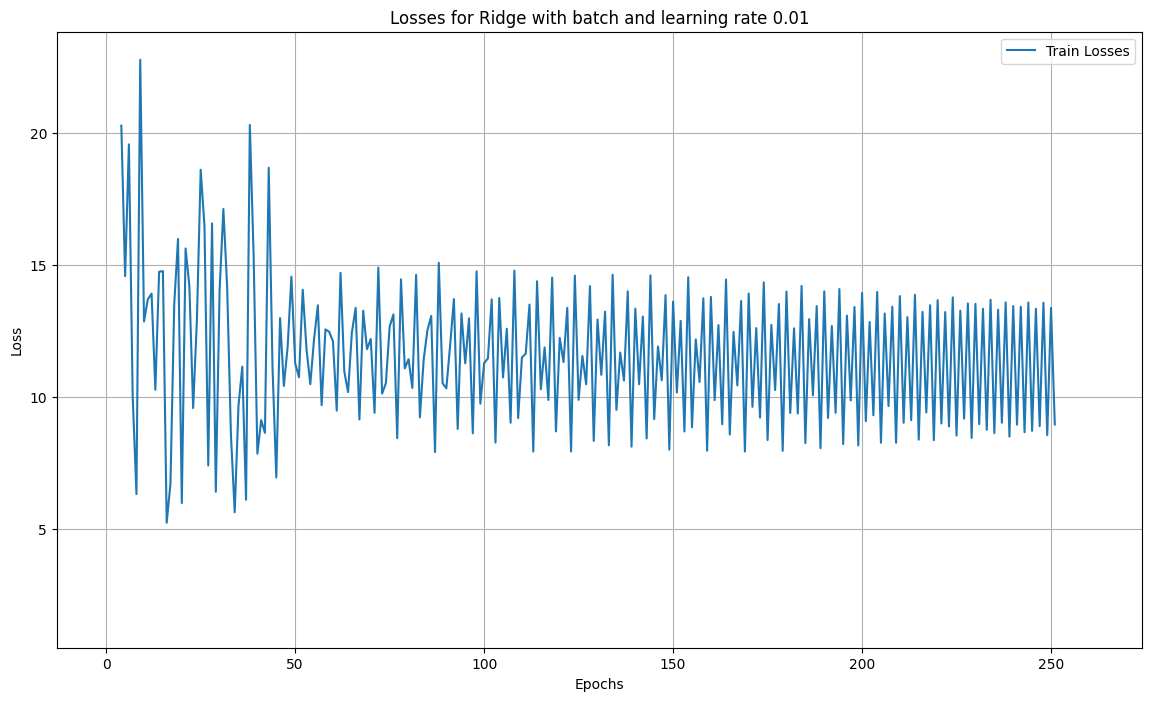

=========Classification report=======
             precision recall f1-score support
0                 0.93   0.56      0.7   411.0
1                 0.52   0.88     0.65   456.0
2                 0.51   0.08     0.14   352.0
3                 0.68   0.93     0.79   387.0
accuracy                          0.64    1606
macro avg         0.66   0.61     0.57  1606.0
weighted avg      0.66   0.64     0.58  1606.0
===== Training Ridge with batch and learning rate 0.001 =====
Loss at iteration 0 1.6122144612855205
Loss at iteration 500 1.1172170525343028
Loss at iteration 1000 1.0947018930395624
Loss at iteration 1500 1.089429074563549
Loss at iteration 2000 1.0872019214182116
Loss at iteration 2500 1.0858405214141813
Loss at iteration 3000 1.0848785574187938
Loss at iteration 3500 1.0841699294481737
Loss at iteration 4000 1.0836442346362505
Loss at iteration 4500 1.0832546598530342
time taken: 3.896484136581421


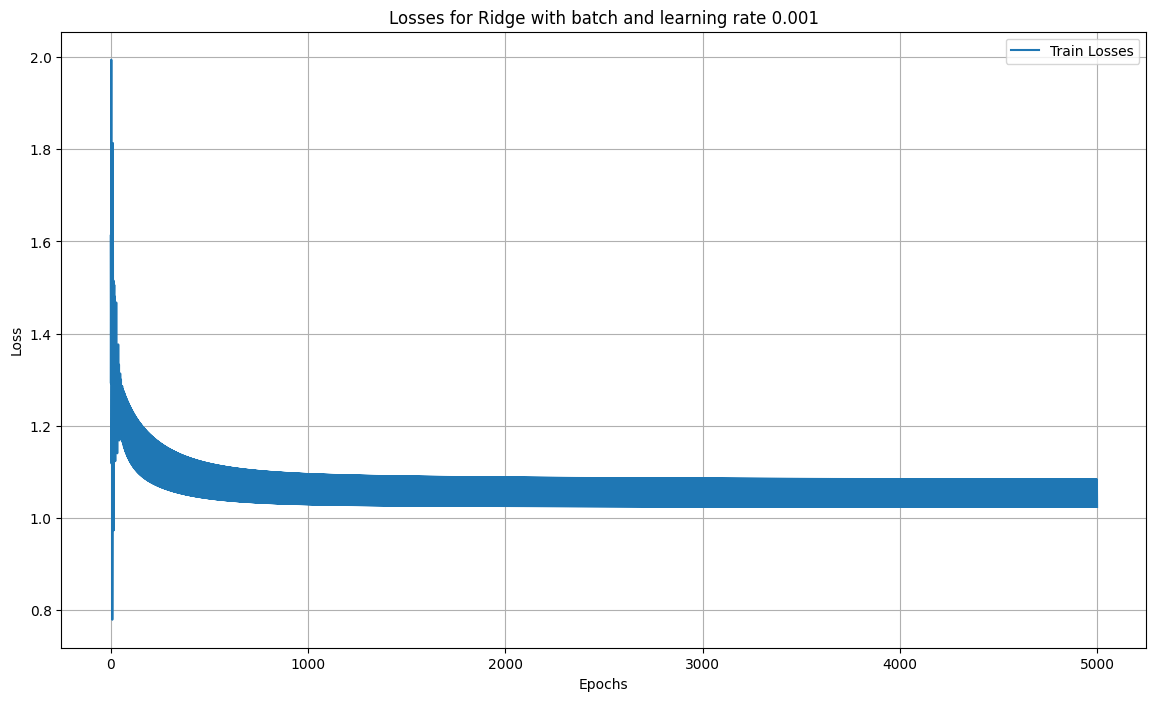

=========Classification report=======
             precision recall f1-score support
0                 0.93   0.62     0.74   411.0
1                 0.54   0.87     0.66   456.0
2                 0.53   0.11     0.19   352.0
3                 0.69   0.93     0.79   387.0
accuracy                          0.65    1606
macro avg         0.67   0.63      0.6  1606.0
weighted avg      0.67   0.65     0.61  1606.0
===== Training Ridge with batch and learning rate 0.0001 =====
Loss at iteration 0 1.5280778036187024
Loss at iteration 500 0.6104049221430538
Loss at iteration 1000 0.5933619167549106
Loss at iteration 1500 0.5874991516996914
Loss at iteration 2000 0.5848339506946536
Loss at iteration 2500 0.5834235127364532
Loss at iteration 3000 0.5825882767932458
Loss at iteration 3500 0.5820457134432873
Loss at iteration 4000 0.5816648398617623
Loss at iteration 4500 0.5813799020996434
time taken: 3.2161970138549805


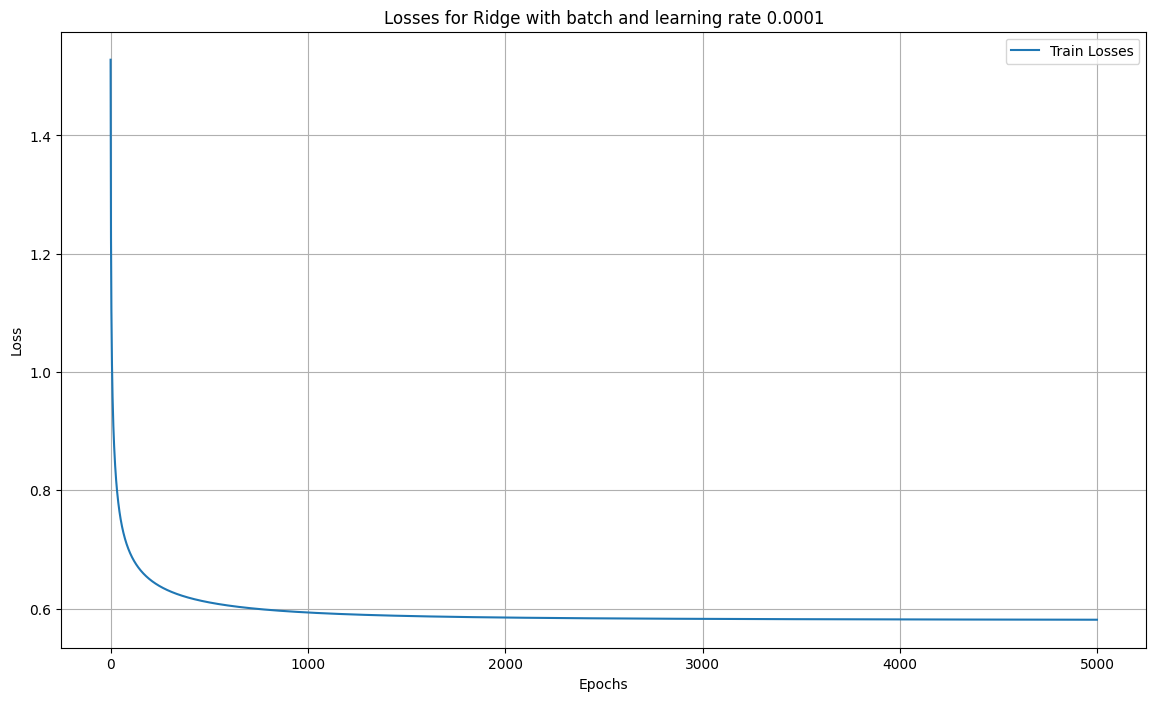

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.85     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.3691417512228086
Loss at iteration 500 6.3108233675853205
Loss at iteration 1000 4.022108721829714
Loss at iteration 1500 4.073445727955218
Loss at iteration 2000 2.00604584698928
Loss at iteration 2500 1.8680176436865104
Loss at iteration 3000 4.964674799781024
Loss at iteration 3500 3.201123965290962
Loss at iteration 4000 4.903581372466675
Loss at iteration 4500 2.3561282977576883
time taken: 1.879136085510254


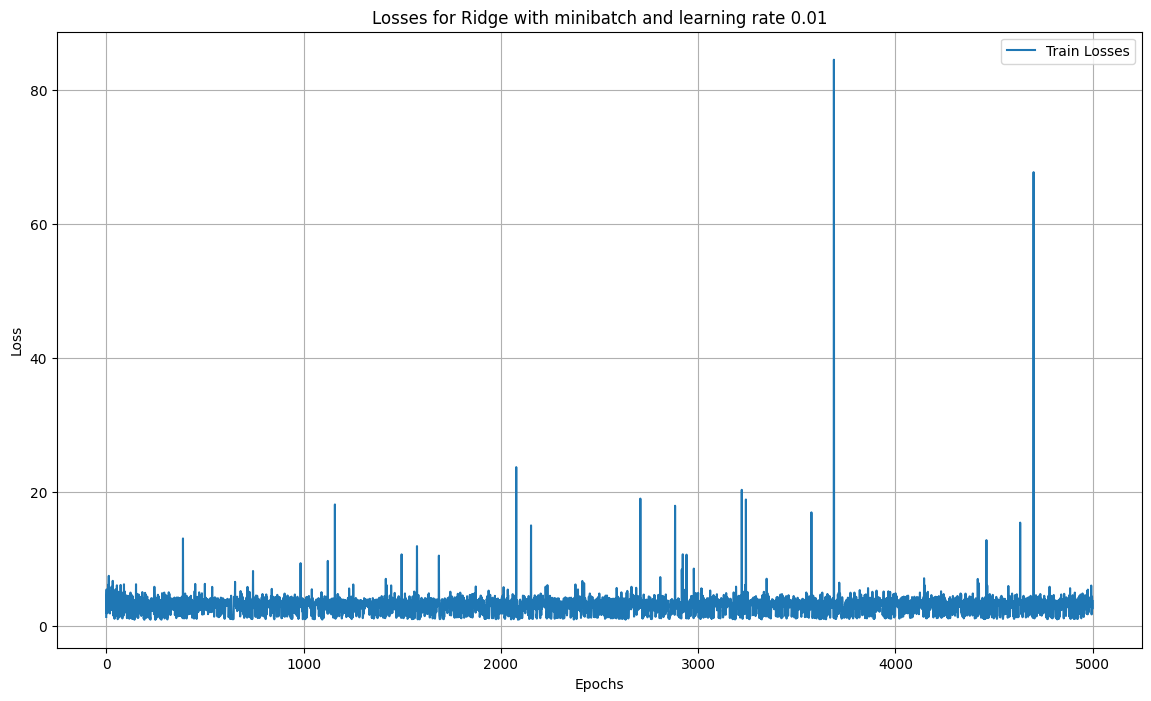

=========Classification report=======
             precision recall f1-score support
0                 0.69   0.96      0.8   411.0
1                  0.7   0.11     0.19   456.0
2                 0.45   0.91     0.61   352.0
3                 0.95   0.61     0.75   387.0
accuracy                          0.62    1606
macro avg          0.7   0.65     0.58  1606.0
weighted avg       0.7   0.62     0.57  1606.0
===== Training Ridge with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.470202452310116
Loss at iteration 500 0.608806546766096
Loss at iteration 1000 0.6138634789135001
Loss at iteration 1500 0.598494481907761
Loss at iteration 2000 0.5923468152452823
Loss at iteration 2500 0.6000379673094371
Loss at iteration 3000 0.6009070410694659
Loss at iteration 3500 0.5885422842916173
Loss at iteration 4000 0.5762292416265458
Loss at iteration 4500 0.5688918884989727
time taken: 1.118865966796875


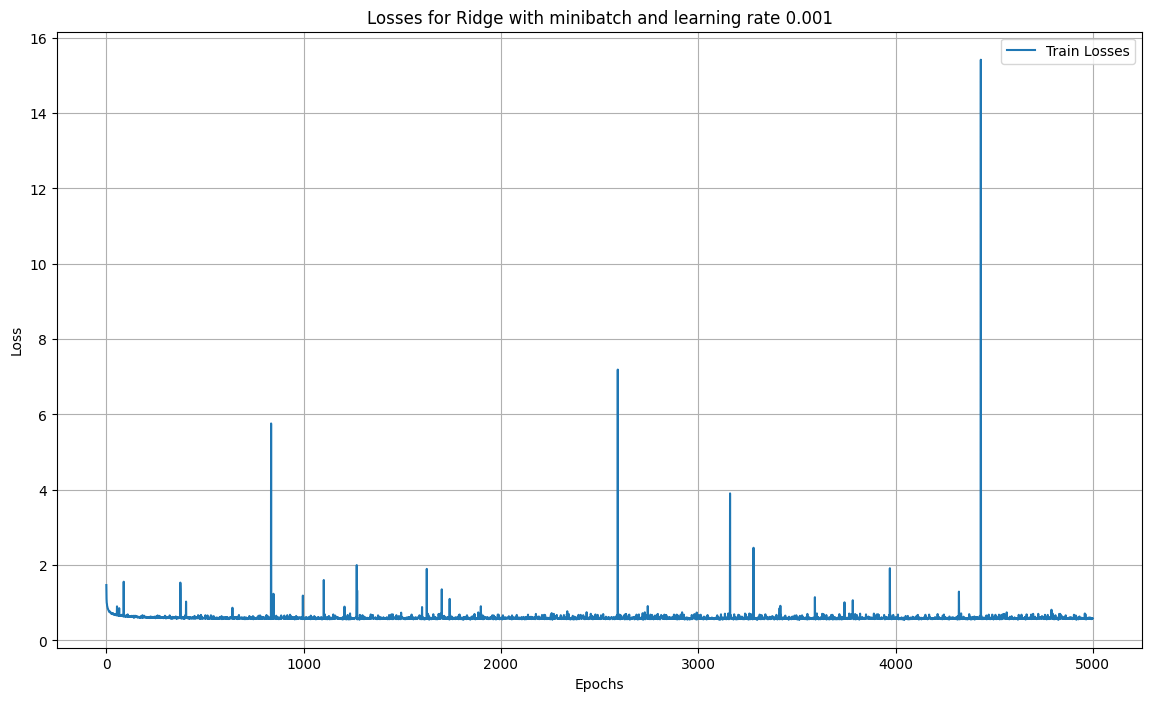

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.83     0.84   411.0
1                  0.7   0.69     0.69   456.0
2                 0.63    0.7     0.66   352.0
3                 0.88   0.84     0.86   387.0
accuracy                          0.76    1606
macro avg         0.77   0.76     0.76  1606.0
weighted avg      0.77   0.76     0.76  1606.0
===== Training Ridge with minibatch and learning rate 0.0001 =====
Loss at iteration 0 1.5459417925629158
Loss at iteration 500 0.6740913091431089
Loss at iteration 1000 0.6336605418895899
Loss at iteration 1500 0.6167938533842395
Loss at iteration 2000 0.6026392439438955
Loss at iteration 2500 0.5981163297266144
Loss at iteration 3000 0.6005861098430799
Loss at iteration 3500 0.5826677706385079
Loss at iteration 4000 0.5854681097957103
Loss at iteration 4500 0.5957707890218888
time taken: 0.9869508743286133


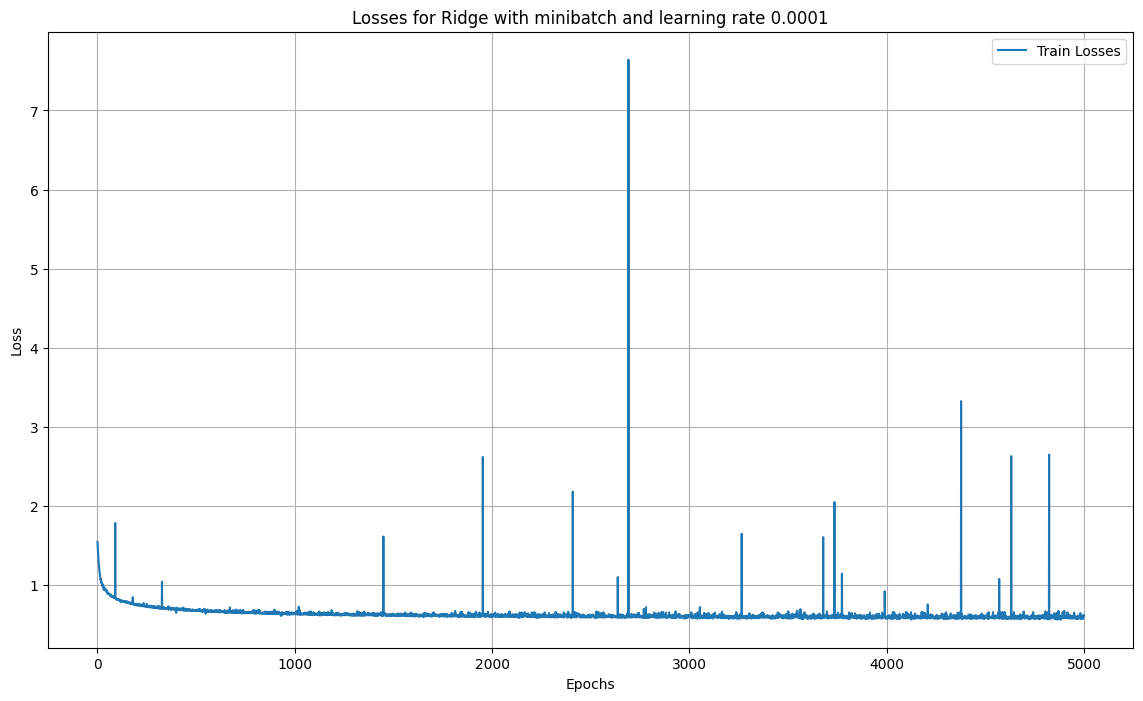

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.82     0.83   411.0
1                  0.7   0.68     0.69   456.0
2                 0.62   0.69     0.66   352.0
3                 0.88   0.84     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with sto and learning rate 0.01 =====
Loss at iteration 0 4.630052355268361
Loss at iteration 500 1.3556802421549425
Loss at iteration 1000 1.675055269735935
Loss at iteration 1500 0.8042942640603544
Loss at iteration 2000 1.269643132278979
Loss at iteration 2500 1.0003629720717007
Loss at iteration 3000 0.8673811996356557
Loss at iteration 3500 1.1017991986241824
Loss at iteration 4000 1.0529232866287521
Loss at iteration 4500 1.4271380568606384
time taken: 0.11248064041137695


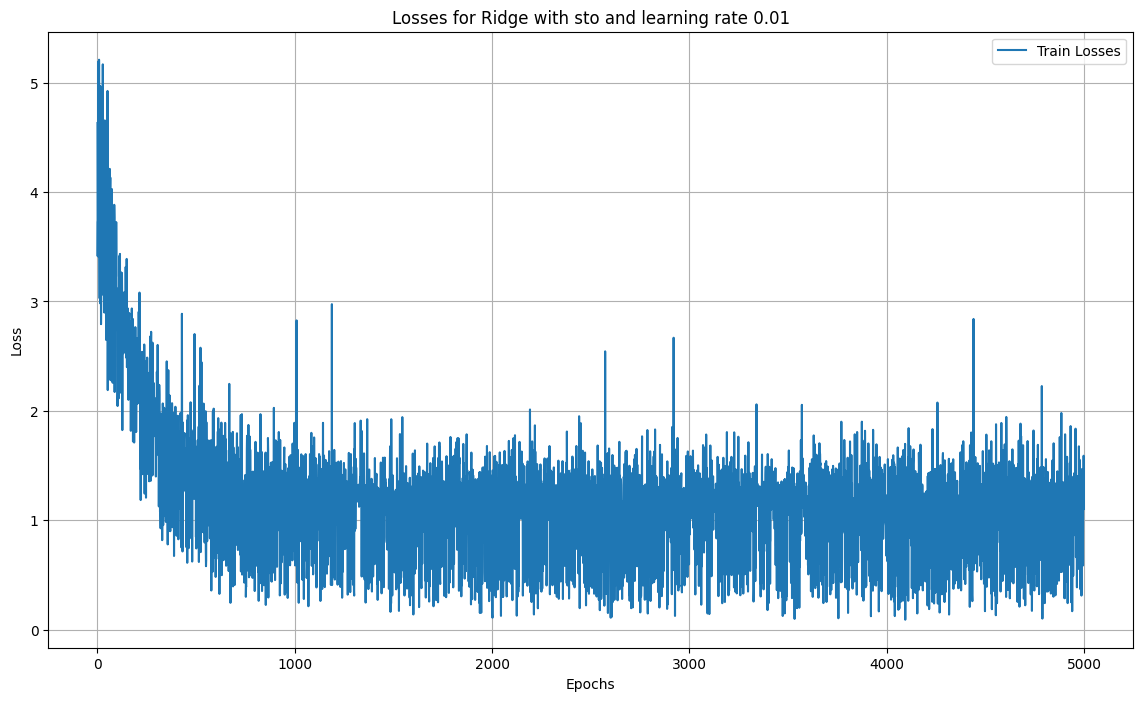

=========Classification report=======
             precision recall f1-score support
0                 0.64   0.89     0.74   411.0
1                 0.46   0.09     0.16   456.0
2                 0.43   0.72     0.54   352.0
3                  0.8   0.71     0.75   387.0
accuracy                          0.58    1606
macro avg         0.58    0.6     0.55  1606.0
weighted avg      0.58   0.58     0.53  1606.0
===== Training Ridge with sto and learning rate 0.001 =====
Loss at iteration 0 3.981782263319119
Loss at iteration 500 3.3448467026778133
Loss at iteration 1000 3.069887078703747
Loss at iteration 1500 2.58267213479051
Loss at iteration 2000 2.213561542331489
Loss at iteration 2500 1.8812394159498262
Loss at iteration 3000 1.8050380526552985
Loss at iteration 3500 2.149523363600507
Loss at iteration 4000 0.8232919727069485
Loss at iteration 4500 1.0795622650614312
time taken: 0.14060020446777344


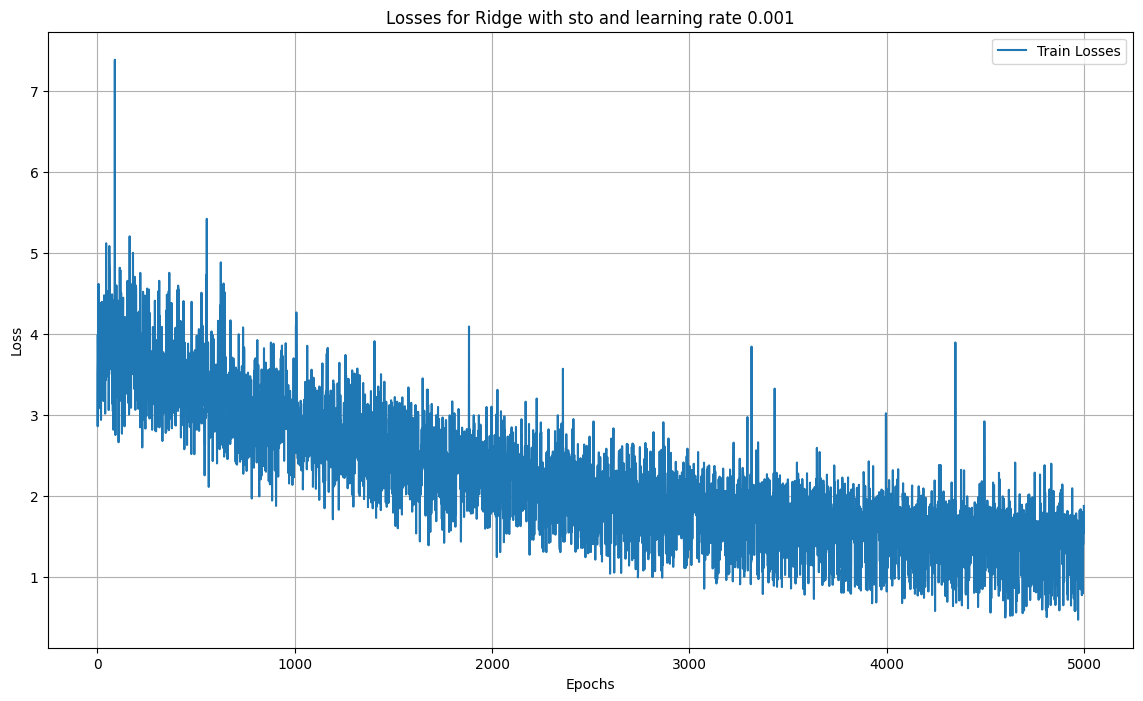

=========Classification report=======
             precision recall f1-score support
0                 0.64   0.91     0.75   411.0
1                 0.43   0.28     0.34   456.0
2                 0.47   0.46     0.47   352.0
3                 0.74   0.73     0.73   387.0
accuracy                          0.59    1606
macro avg         0.57    0.6     0.57  1606.0
weighted avg      0.57   0.59     0.57  1606.0
===== Training Ridge with sto and learning rate 0.0001 =====
Loss at iteration 0 4.607768483720337
Loss at iteration 500 4.398131837184906
Loss at iteration 1000 5.3746195937822225
Loss at iteration 1500 4.24424484130939
Loss at iteration 2000 4.3277387980876485
Loss at iteration 2500 4.518003761476326
Loss at iteration 3000 3.158908797655423
Loss at iteration 3500 3.2256512550008356
Loss at iteration 4000 3.3117321612493336
Loss at iteration 4500 4.428332133135811
time taken: 0.1268758773803711


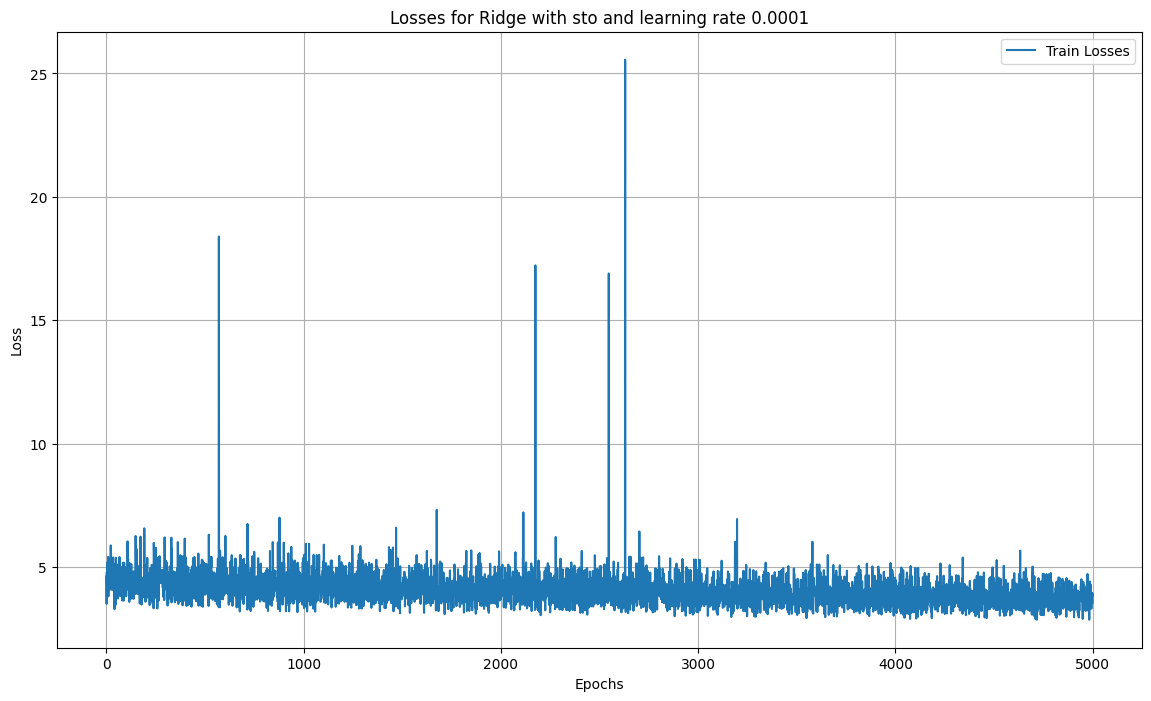

=========Classification report=======
             precision recall f1-score support
0                 0.32   0.56     0.41   411.0
1                 0.32   0.14      0.2   456.0
2                 0.28   0.49     0.35   352.0
3                 0.78    0.1     0.18   387.0
accuracy                          0.32    1606
macro avg         0.43   0.33     0.29  1606.0
weighted avg      0.42   0.32     0.28  1606.0


In [25]:
# Loop through different models, methods, and learning rates
regs = ["SimpleLogistic", "Ridge"]
methods = ["batch", "minibatch", "sto"]
alphas = [0.01, 0.001, 0.0001]

for reg in regs:
    for method in methods:
        for alpha in alphas:

                if reg == "Ridge": # Check if Ridge to add l2 parameter
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha,
                        "l2": 0.1
                    }
                else:
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha
                    }

                with mlflow.start_run(run_name=f"{reg}-method-{method}-learning_rate-{alpha}", nested=True):

                    print("=" * 5, f"Training {reg} with {method} and learning rate {alpha}", "=" * 5)
                    
                    for key, value in params.items():
                        mlflow.log_param(key, value)

                    logis_type = str_to_class(reg)
                    model = logis_type(**params)
                    # Train the model and predict
                    model.fit(X_train_transformed, y_train_one_hot)
                    yhat = model.predict(X_test_transformed)
                    # Plot the losses
                    fig, ax = plt.subplots(figsize=(14,8))
                    model.plot()
                    plt.title(f"Losses for {reg} with {method} and learning rate {alpha}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.grid()
                    if not os.path.exists("./figures"):
                        os.makedirs("./figures")
                    # Save figure image to figure folder
                    fig_path = f"./figures/{reg}-{method}-{alpha}.png"
                    plt.savefig(fig_path)
                    mlflow.log_artifact(fig_path, artifact_path="figures")
                    plt.show()
                    print("=========Classification report=======")
                    print(model.classification_report(y_test, yhat))
                    # Log all metrics to MLflow calculate function by function
                    acc = model.accuracy(y_test, yhat) # accuracy
                    macro_prec = model.macro_precision(y_test, yhat) # macro precision
                    macro_rec = model.macro_recall(y_test, yhat) # macro recall
                    macro_f1 = model.macro_f1_score(y_test, yhat) # macro f1
                    weighted_prec = model.weighted_precision(y_test, yhat) # weighted precision
                    weighted_rec = model.weighted_recall(y_test, yhat) # weighted recall
                    weighted_f1 = model.weighted_f1_score(y_test, yhat) # weighted f1
                    mlflow.log_metric("accuracy", acc)
                    mlflow.log_metric("macro_precision", macro_prec)
                    mlflow.log_metric("macro_recall", macro_rec)
                    mlflow.log_metric("macro_f1", macro_f1)
                    mlflow.log_metric("weighted_precision", weighted_prec)
                    mlflow.log_metric("weighted_recall", weighted_rec)
                    mlflow.log_metric("weighted_f1", weighted_f1)
                    for cls in np.unique(y_test):
                        prec = model.precision(y_test, yhat, cls) # precision for each class
                        rec = model.recall(y_test, yhat, cls) # recall for each class
                        f1 = model.f1_score(y_test, yhat, cls) # f1 for each class
                        mlflow.log_metric(f"precision_class_{cls}", prec)
                        mlflow.log_metric(f"recall_class_{cls}", rec)
                        mlflow.log_metric(f"f1_score_class_{cls}", f1)
                    # signature = mlflow.models.infer_signature(X_train_transformed, yhat)
                    # mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)


In [26]:
# Find the best model 
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

# Create an MLflow client and get the experiment by name
client = MlflowClient()
experiment = client.get_experiment_by_name("st126235-a3")

# Pull runs in experiment then sort to find best macro_f1 (Use macro_f1 as main metric because it is balanced for all classes and not affected by class imbalance)
runs = client.search_runs(
    [experiment.experiment_id],
    order_by=["metrics.macro_f1 DESC"],
    max_results = 1
)

# Display the best run details
best_run = runs[0]
run_id = best_run.info.run_id
print("Best run ID:", run_id)
print("Best macro_f1:", best_run.data.metrics["macro_f1"])

Best run ID: 5abc470ffc8d45eb8dc2bf0f41709451
Best macro_f1: 0.767900072565735


Best run parameters: {'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}
Loss at iteration 0 1.5519622031891103
Loss at iteration 500 0.5900003479814613
Loss at iteration 1000 0.5897811997539626
Loss at iteration 1500 0.5847625632406241
Loss at iteration 2000 0.5670343103341227
Loss at iteration 2500 0.5746627439958613
Loss at iteration 3000 0.5813438170001619
Loss at iteration 3500 0.5884231787433811
Loss at iteration 4000 0.5883584632354335
Loss at iteration 4500 0.5928069328263007
time taken: 1.8013439178466797


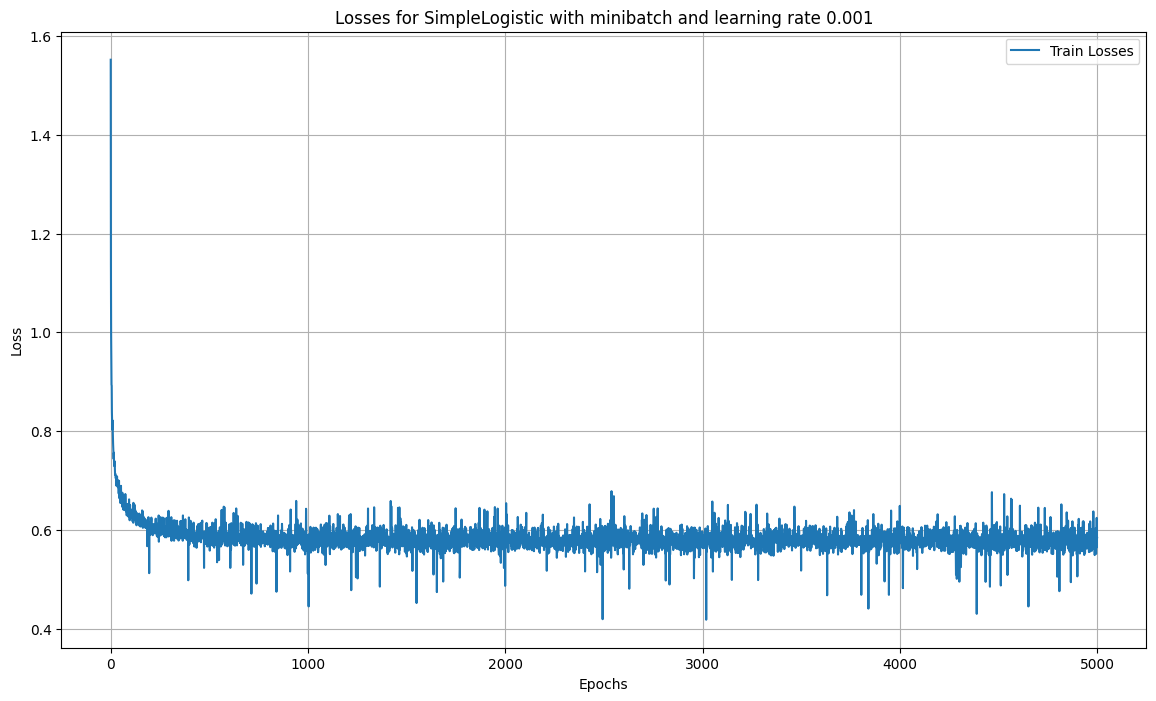

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.84     0.85   411.0
1                 0.71    0.7      0.7   456.0
2                 0.63    0.7     0.66   352.0
3                 0.88   0.84     0.86   387.0
accuracy                          0.77    1606
macro avg         0.77   0.77     0.77  1606.0
weighted avg      0.77   0.77     0.77  1606.0


2025/10/05 11:29:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Current run ID: 1b3960eb2d0f4043a2c3e47ea058e87a


In [27]:
# Log model to MLFlow for the best run
params = best_run.data.params
print("Best run parameters:", params)
# Create a new run to log the best model
with mlflow.start_run(run_name=f"Best_model_{run_id}") as run:
    # Check if params includes l2 for Ridge or not for SimpleLogistic
    if 'l2' in params:
        model = Ridge(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha']),
            l2=float(params['l2'])
        )
    else:
        model = SimpleLogistic(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha'])
        )
    mlflow.log_params(params)
    # Train the model and predict
    model.fit(X_train_transformed, y_train_one_hot)
    yhat = model.predict(X_test_transformed)
    # Plot training history
    fig, ax = plt.subplots(figsize=(14,8))
    model.plot()
    regbest = 'SimpleLogistic' if 'l2' not in params else 'Ridge'
    methodbest = params['method']
    alphabest = params['alpha']
    plt.title(f"Losses for {regbest} with {methodbest} and learning rate {alphabest}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    # Save figure image to figure folder
    fig_path = f"./figures/best-{regbest}-{methodbest}-{alphabest}.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path, artifact_path="figures")
    plt.show()
    print("=========Classification report=======")
    print(model.classification_report(y_test, yhat))
    # Log all metrics to MLflow calculate function by function
    acc = model.accuracy(y_test, yhat) # accuracy
    macro_prec = model.macro_precision(y_test, yhat) # macro precision
    macro_rec = model.macro_recall(y_test, yhat) # macro recall
    macro_f1 = model.macro_f1_score(y_test, yhat) # macro f1
    weighted_prec = model.weighted_precision(y_test, yhat) # weighted precision
    weighted_rec = model.weighted_recall(y_test, yhat) # weighted recall
    weighted_f1 = model.weighted_f1_score(y_test, yhat) # weighted f1
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("macro_precision", macro_prec)
    mlflow.log_metric("macro_recall", macro_rec)
    mlflow.log_metric("macro_f1", macro_f1)
    mlflow.log_metric("weighted_precision", weighted_prec)
    mlflow.log_metric("weighted_recall", weighted_rec)
    mlflow.log_metric("weighted_f1", weighted_f1)
    for cls in np.unique(y_test):
        prec = model.precision(y_test, yhat, cls) # precision for each class
        rec = model.recall(y_test, yhat, cls) # recall for each class
        f1 = model.f1_score(y_test, yhat, cls) # f1 for each class
        mlflow.log_metric(f"precision_class_{cls}", prec)
        mlflow.log_metric(f"recall_class_{cls}", rec)
        mlflow.log_metric(f"f1_class_{cls}", f1)
    signature = mlflow.models.infer_signature(X_train_transformed, yhat) # infer model signature
    mlflow.sklearn.log_model(model, artifact_path="model", signature=signature) # log the model

    current_run_id = run.info.run_id # Get the current run ID
    print("Current run ID:", current_run_id)

In [28]:
# Register model
model_uri = f"runs:/{current_run_id}/model" # Use the current run ID to get the model URI
model_name = "st126235-a3-model" # Define the model name
try:
    result = mlflow.register_model(model_uri, model_name) # Register the model
    print(f"Model registered: {result.name}, version: {result.version}")
    model_version = result.version # Get the model version
    # Add time sleep
    time.sleep(2)  # Wait for a few seconds to ensure the model is registered
except RestException as e:
    print(f"Model registration failed: {e}")

Registered model 'st126235-a3-model' already exists. Creating a new version of this model...
2025/10/05 11:29:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126235-a3-model, version 10
Created version '10' of model 'st126235-a3-model'.


Model registered: st126235-a3-model, version: 10


In [29]:
# Check registered model in mlflow
for rm in mlflow.search_registered_models():
    if rm.name == model_name:
        print(f"Model name: {rm.name}")
        for mv in rm.latest_versions:
            print(f"  Version: {mv.version}, Stage: {mv.current_stage}, Status: {mv.status}")

Model name: st126235-a3-model
  Version: 8, Stage: Archived, Status: READY
  Version: 6, Stage: Production, Status: READY
  Version: 10, Stage: None, Status: READY
  Version: 9, Stage: Staging, Status: READY


In [30]:
print(mlflow.__version__) # Check MLflow version

2.8.1


In [31]:
# Check if model version exists and is ready

try:
    model_version_details = client.get_model_version(name=model_name, version=model_version) # Get model version details
    print(f"Model version status: {model_version_details.status}")
    
    if model_version_details.status == "READY":
        # Add alias to the model version
        alias_name = "Staging"
        try:
            # Ensure the version is passed as a string to set_registered_model_alias
            client.set_registered_model_alias(name=model_name, alias=alias_name, version=str(model_version))
            print(f"Alias '{alias_name}' set for model version {model_version}")
        except Exception as e:
            print(f"Failed to set alias: {e}")
        # Transition the model to staging
        client.transition_model_version_stage(
            name=model_name, 
            version=int(model_version), 
            stage="Staging",
            archive_existing_versions=True
        )
        print(f"Model version {model_version} transitioned to Staging")
    else:
        print(f"Model version not ready. Current status: {model_version_details.status}")
        
except Exception as e:
    print(f"Error during transition: {e}")

Model version status: READY
Alias 'Staging' set for model version 10
Model version 10 transitioned to Staging


In [32]:
# Load staging model
loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}/staging")

In [33]:
# Inference with the model
synthetic_data = {
    'year': [2014, 2015],
    'km_driven': [50000, 30000],
    'fuel': ['Diesel', 'Petrol'],
    'transmission': ['Manual', 'Automatic'],
    'owner': [1, 1],
    'engine': [1500, 1200],
    'max_power': [100, 80],
    'brand': ['Maruti', 'Hyundai'],
    'mileage': [18.0, 20.0]
}
# Create a DataFrame for synthetic data
X_synthetic = pd.DataFrame(synthetic_data)
# Preprocess the synthetic data
X_synthetic_transformed = prep.transform(X_synthetic)
# Predict the class using the loaded model
predictions = loaded_model.predict(X_synthetic_transformed)
# Display the predictions
print("Details of synthetic data samples:\n", X_synthetic)
print("The first synthetic data sample predicted class:", predictions[0])
print("The second synthetic data sample predicted class:", predictions[1])


Details of synthetic data samples:
    year  km_driven    fuel transmission  owner  engine  max_power    brand  \
0  2014      50000  Diesel       Manual      1    1500        100   Maruti   
1  2015      30000  Petrol    Automatic      1    1200         80  Hyundai   

   mileage  
0     18.0  
1     20.0  
The first synthetic data sample predicted class: 3
The second synthetic data sample predicted class: 1


In [34]:
# Conclude the best model parameters
print("Best model parameters:", params)

Best model parameters: {'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}


## Experiment Report